In [1]:
# Reload custom modules when modified
%load_ext autoreload
%autoreload 2

In [2]:
# Import common libraries
import torch
import numpy as np
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Custom notebook setup
%run setup_notebook.py

- adding project root in Python path
- setting default torch dtype to float64
- overriding matplotlib aesthetics


In [4]:
# Load project modules
from src.inference import compute_logdet
from src.utils import compute_logdet_bounds

# Sampling functions from the prior

We briefly explore how the choice of a kernel induces a prior distribution and the different shapes of the priors with different kernels.

The prior Gaussian Process is just the multivariate normal distribution with the kernel matrix as the covariance, since there is no data to condition the distribution on. With $x_i^\star$ the test points,

$$\mathbf y^\star \sim \mathcal N(\mathbf 0, K_{XX}), \quad (K_{XX})_{ij} = k(x_i, x_j)$$

In [226]:
# Kernels to compare
kernels = [
    # | --- class object ---| |-- name -|  |-- parameters ----|
    (SquaredExponentialKernel, 'SE',     {'length_scale': 0.1}),
    (SquaredExponentialKernel, 'SE',     {'length_scale': 1.0}),
    (MaternKernel,             'Matern', {'length_scale': 0.1, 'nu': 1.5}),
    (MaternKernel,             'Matern', {'length_scale': 0.3, 'nu': 2.5})
]

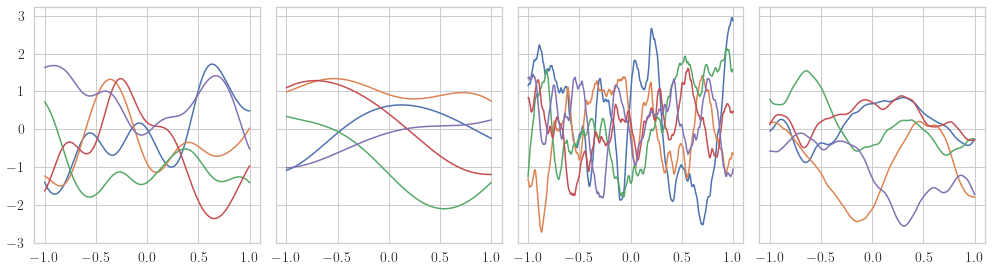

In [228]:
# Nodes
n = 500
nodes = torch.linspace(-1, 1, n)
# Number of prior functions tu sample
N = 5

_, ax = plt.subplots(1, len(kernels), figsize=(len(kernels) * 3.5, 4), sharex=True, sharey=True)

for i, (kernel, desc, params) in enumerate(kernels):
    # Compute kernel matrix
    K = kernel(**params).compute(nodes)
    # Sample from multivariate normal
    f = np.random.multivariate_normal(mean=np.zeros(n), cov=K, size=N)
    # Plot
    ax[i].plot(nodes, f.T)
    
plt.tight_layout()

# Preconditionning the kernel matrix

Kernel matrices are extremely ill-conditionned, so that computing their eigenvalues with standard algorithms will fail, as shown by the example below:

In [6]:
from src.kernel import SquaredExponentialKernel, MaternKernel

In [8]:
# Uniform grid on [0, 1] of n points
n = 100
x = torch.linspace(0., 1., n)

# Compute kernel matrix
lengthscale = 2.0
K = SquaredExponentialKernel(lengthscale).compute(x)

# Eigenvalues
eigs = torch.linalg.eigvalsh(K)
eigs.min()

tensor(-8.8562e-15)

Here, the computed minimum eigenvalue is $\tilde \lambda_{\min} < 0$, but we know that the true eigenvalue $\lambda_{\min} > 0$ since $K$ is SPD. Note that we won't work with $K$ directly but rather with $\widehat K := K + \sigma^2 I$, which is a very good news since $\widehat K$ is much better conditionned. However, we will rely on Lanczos algorithm to approximate some quantities, and we need the number of Lanczos steps to scale with the square root of the condition number. Therefore, we wish to accelerate the convergence of Lanczos.


We explore how the condition number of the preconditionned matrix 

$$ \widehat P^{-\frac 1 2}_k \widehat K_{XX} \widehat P^{-\frac 1 2}_k$$

behaves as a function of $k := \text{rank}(P_k)$ with $P_k = L_kL_k^\top \approx K_{XX}$. Let us start with the simple squared exponential kernel:

In [9]:
from src.precond import PartialCholesky

In [10]:
n = 1000
x = torch.linspace(0., 1., n)
lengthscale = 2.0
sigma2 = 0.5
K = SquaredExponentialKernel(lengthscale).compute(x)
#K = MaternKernel(lengthscale, 1.5).compute(x)
Khat = K + torch.eye(n) * sigma2

In [11]:
# Tolerance of pivoted Cholesky
tol = 1e-10

# Values of the rank of the preconditionner to explore, 
# A priori, the rank required for convergence is unknown
ks_explore = range(1, n)

# Initialize metrics
cond_nums = []

# Try each rank
for k in ks_explore:
    print(f'k={k}', end=', ')
    # Compute eigenvalues of preconditionned matrix with rank <= k
    P = PartialCholesky(K, k, sigma2, tol=tol)
    precond_eigs = P.compute_precond_eigs()
    
    # Extract the rank of the preconditionner
    rank = P.k
    # Extract the trace norm errors of the pivoted Cholesky algo
    trace_errors = P.trace_errors
    
    # If the rank does not increase, pivoted Cholesky converged -> stop iterating
    if rank < k:
        break
    
    # Compute the condition number of the preconditionned matrix
    cond_nums.append(precond_eigs.max() / precond_eigs.min())
    
# Add metrics for the original matrix without preconditionning (i.e., k=0)
cond_nums.insert(0, torch.linalg.cond(Khat))
trace_errors.insert(0, Khat.trace())
# Build the list of ranks that were actually explored
ks = list(range(0, len(cond_nums)))

k=1, k=2, k=3, k=4, k=5, k=6, k=7, k=8, k=9, pivoted cholesky converged after 8 steps


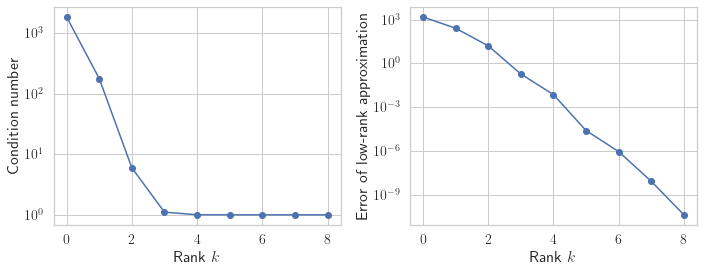

In [12]:
_, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

ax[0].semilogy(ks, cond_nums, '-o')
ax[1].semilogy(ks, trace_errors, '-o')

# Aesthetics
for a in ax: a.set_xlabel('Rank $k$')
ax[0].set_ylabel('Condition number')
ax[1].set_ylabel('Error of low-rank approximation')
plt.tight_layout()

Now that the code is setup, let us repeat it more concisely while comparing different kernels:


In [381]:
tol = 1e-10
ks_explore = range(1, 11)

sigma2 = 0.5

# Kernels to compare
kernels = [
    # | --- class object ---| |-- name -|  |-- parameters ----|
    (SquaredExponentialKernel, 'SE',     {'length_scale': 0.1}),
    (SquaredExponentialKernel, 'SE',     {'length_scale': 1.0}),
    (MaternKernel,             'Matern', {'length_scale': 1.0, 'nu': 1.5}),
    (MaternKernel,             'Matern', {'length_scale': 1.0, 'nu': 2.5})
]

cond_nums = []
trace_errors = []
ks = []

n = 1000
x = torch.linspace(0, 1, n)
for i, (kernel, name, parameters) in enumerate(kernels):
    # Initialize
    cond_nums.append([])
    trace_errors.append([])
    ks.append([])
    
    K = kernel(**parameters).compute(x)
    Khat = K + torch.eye(n) * sigma2
    print(name, end=' ')
    for k in ks_explore:
        print(f'k={k}', end=', ')
        # Compute eigenvalues of preconditionned matrix with rank <= k
        P = PartialCholesky(K, k, sigma2, tol=tol)
        precond_eigs = P.compute_precond_eigs()

        # Extract the rank of the preconditionner
        rank = P.k
        # Extract the trace norm errors of the pivoted Cholesky algo
        trace_errors[i] = P.trace_errors

        # If the rank does not increase, pivoted Cholesky converged -> stop iterating
        if rank < k:
            break

        # Compute the condition number of the preconditionned matrix
        cond_nums[i].append(precond_eigs.max() / precond_eigs.min())

    # Add metrics for the original matrix without preconditionning (i.e., k=0)
    cond_nums[i].insert(0, torch.linalg.cond(Khat))
    trace_errors[i].insert(0, Khat.trace())
    # Build the list of ranks that were actually explored
    ks[i] = list(range(0, len(cond_nums[i])))
    print(f'final tr-err = {trace_errors[i][-1]:.3}')

SE k=1, k=2, k=3, k=4, k=5, k=6, k=7, k=8, k=9, k=10, final tr-err = 0.00263
SE k=1, k=2, k=3, k=4, k=5, k=6, k=7, k=8, k=9, k=10, pivoted cholesky converged after 9 steps
final tr-err = 4.62e-11
Matern k=1, k=2, k=3, k=4, k=5, k=6, k=7, k=8, k=9, k=10, final tr-err = 0.207
Matern k=1, k=2, k=3, k=4, k=5, k=6, k=7, k=8, k=9, k=10, final tr-err = 0.00297


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


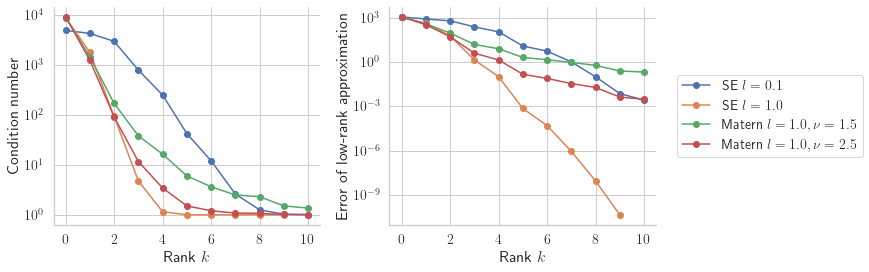

In [382]:
# Parameter map
param_map = {
    'length_scale': 'l', 'nu': r'\nu'
}

_, ax = plt.subplots(1, 2, figsize=(13, 4), sharex=True)

for i, (kernel, name, params) in enumerate(kernels):
    label_params = ', '.join(f'{param_map[param]}={value}' for param, value in params.items())
    
    ax[0].semilogy(ks[i], cond_nums[i], '-o', label=f'{name} ${label_params}$')
    ax[1].semilogy(ks[i], trace_errors[i], '-o', label=f'{name} ${label_params}$')
    
# Aesthetics
for a in ax: a.set_xlabel('Rank $k$')
ax[0].set_ylabel('Condition number')
ax[1].set_ylabel('Error of low-rank approximation')
plt.legend(bbox_to_anchor=(1.8, .5), loc='center right')
# Save figure
process_figure('kernel_preconditionning')

# mBCG on kernel matrices

In [22]:
from src.cg import mbcg

In [128]:
def callback(error_lst, xtrue):
    """
    Helper callback function: iterative methods (e.g, CG) can be provided a callback function,
    i.e. a function that will be called at each step of the iterative method with the input
    being the current solution. 
    This helper function provides a concise way of measuring the relative error at each step.
    
    :param error_lst: the list in which relative errors will be stored at each step
    :param xtrue: the true solution used to compute the error
    """
    xtrue_norm = (xtrue ** 2).sum() ** 0.5
    def inner(xk):
        """Wrapped function. `inner` will be called by the iterative methhod."""
        error_stepk = xk - xtrue
        # Compute relative error
        error_stepk = (error_stepk ** 2).sum() ** 0.5 / xtrue_norm
        error_lst.append(error_stepk)
        
    return inner

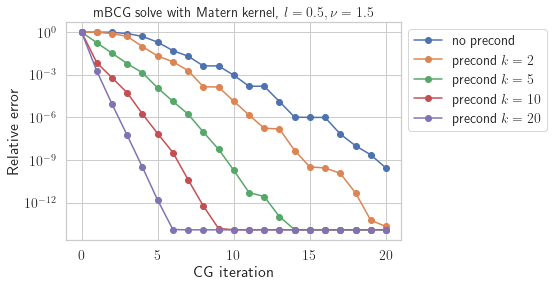

In [264]:
# Build the kernel matrix
n = 1000
sigma2 = 1
lengthscale = 0.5
nu = 1.5

grid = torch.linspace(0, 1, n)
K = MaternKernel(length_scale=lengthscale, nu=nu).compute(grid)
Khat = K + torch.eye(n) * sigma2

# Build the system Ax = b
xtrue = torch.randn(n)
b = Khat @ xtrue

# Solve without preconditionning
k = 20
rel_errs = []
mbcg(lambda X: Khat @ X, lambda X: X, b, torch.zeros(n), k=k, callback=callback(rel_errs, xtrue))
plt.semilogy(rel_errs, '-o', label='no precond')

# Solve with preconditionning
ranks = (2, 5, 10, 20)
for rank in ranks:
    # Compute preconditionner
    P = PartialCholesky(K, max_rank=rank, sigma2=sigma2)
    # Run mBCG
    rel_errs = []
    mbcg(lambda X: Khat @ X, P.inv_fun, b, torch.zeros(n), k=k, callback=callback(rel_errs, xtrue))
    # Plot
    plt.semilogy(rel_errs, '-o', label=f'precond $k={rank}$')

plt.xlabel('CG iteration'); plt.ylabel('Relative error')
plt.title(f'mBCG solve with Matern kernel, $l={lengthscale}, \\nu = {nu}$')
#plt.title('mBCG solve of $\widehat K_' + '_{XX}' + f' x=b$ with Matern kernel, $l={lengthscale}$')
plt.legend(bbox_to_anchor=(1,1));

# Logdet computation

In [267]:
from src.inference import inference

In [501]:
# Parameters
n = 100
sigma2 = 1
lengthscale = 0.1

# Build kernel matrix
nodes = torch.linspace(0, 1, n)
K = SquaredExponentialKernel(length_scale=lengthscale).compute(nodes)
Khat = K + sigma2 * torch.eye(n)
logdet_true = torch.logdet(Khat).item()

We study the convergence w.r.t. the number of probe vectors $N$. We are interested in the 95th quantile of the errors, so we must run several repetitions of the algorithm for each $N$ value. 

Since the code is in Python, it is very slow to call the inference engine many time. However, if we use many probe vectors, the computational overhead is essentially handled by low-level code. We just exploit that probe vectors are iid, so their corresponding logdet estimator are iid as well.

So if we want to call `inference` $r$ times with $N$ probe vectors, we rather call it once with $N\times r$ probe vectors, use the argument `return_avg=False`, and post-process the array. 

In [455]:
def postprocess_results(res, trueval, Ns, q=0.95):
    """
    Given a list of iid estimators, compute the quantiles of the errors by considering different number of samples.
    """
    quantiles = []
    res = np.array(res)
    for N in Ns:
        np.random.shuffle(res)
        estimates = res.reshape(-1, N).mean(axis=1)
        errors = np.abs( (estimates - trueval) / trueval )
        quantile = np.quantile(errors, q)
        quantiles.append(quantile)
    
    return quantiles

## Without preconditionning

CPU times: user 18.6 s, sys: 2.41 s, total: 21 s
Wall time: 12.9 s


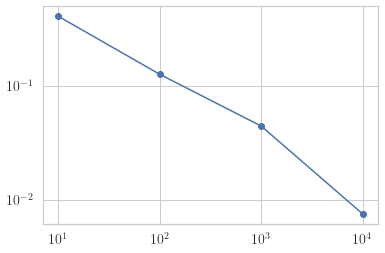

In [502]:
%%time

m = 10
Ns = (10, 100, 1000, 10000)
Ntot = int(1e5)

logdets = inference(K, k=0, sigma2=sigma2, N=Ntot, m=m, return_avg=False)
errors = postprocess_results(logdets, logdet_true, Ns)
plt.loglog(Ns, errors, '-o');

In [503]:
%%time

ms = (1, 10, 50)
N = 100

logdets = [
    inference(K, k=0, sigma2=sigma2, N=Ntot, m=m)
    for m in ms
]

CPU times: user 3min 17s, sys: 14.3 s, total: 3min 31s
Wall time: 1min 11s


In [507]:
errors = np.abs(np.array(logdets) - logdet_true) / logdet_true
errors

array([3.70719305e+00, 2.44917073e-03, 1.30456280e-03])

CPU times: user 18.6 s, sys: 2.41 s, total: 21 s
Wall time: 12.9 s


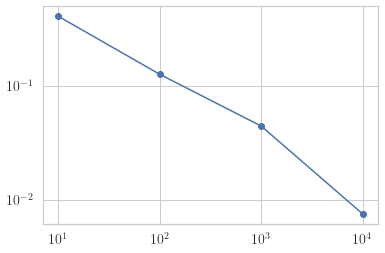

In [502]:
errors = postprocess_results(logdets, logdet_true, Ns)
plt.loglog(Ns, errors, '-o');

## With preconditionning

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CPU times: user 8.64 s, sys: 355 ms, total: 9 s
Wall time: 5.15 s


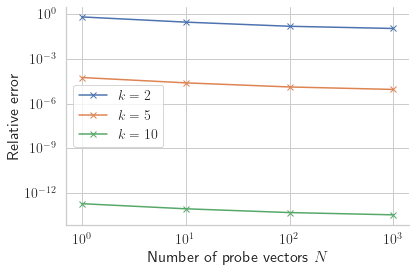

In [474]:
%%time
m = 10

ks = (2, 5, 10)
Ns = (1, 10, 100, 1000)
Ntot = int(1e4)

for k in ks:
    logdets = inference(K, k, sigma2, N=Ntot, m=m, return_avg=False)

    quantiles = postprocess_results(logdets, logdet_true, Ns)

    plt.loglog(Ns, quantiles, '-x', label=f'$k={k}$');

plt.xlabel('Number of probe vectors $N$')
plt.ylabel('Relative error');
plt.legend();
process_figure('logdet_precond')

ValueError: x and y must have same first dimension, but have shapes (3,) and (4,)

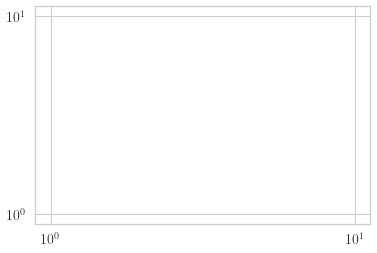

In [471]:
%%time
N = 10

ks = (2, 5, 10)
ms = (1, 10, 100)
Ntot = int(1e4)

for k in ks:
    logdets = inference(K, k, sigma2, N=Ntot, m=m, return_avg=False)

    quantiles = postprocess_results(logdets, logdet_true, Ns)

    plt.loglog(ms, quantiles, '-x', label=f'$m={m}$');

plt.xlabel('Number of probe vectors $N$')
plt.ylabel('Relative error');
plt.legend();

# Error Lanczos quadrature

The error upperbound is (see Cortinovis paper):
$$
|\mathbf x^\top \log(A) \mathbf x - \Vert \mathbf x \Vert_2^2 \mathbf e_1^\top log(T_m) \mathbf e_1 |
\le c_a \Vert \mathbf x \Vert_2^2 \left( \frac{\sqrt{\kappa(A) + 1} - 1}{\sqrt{\kappa(A) + 1} + 1} \right) ^{2m},
\quad c_A := 2 ( \sqrt{\kappa(A) + 1} + 1) \log(2\kappa(A))
$$

Aim: for a SPD matrix $A$ with known eigenvalues, compute some big number of Lanczos steps $M$ and visualize the error for different numbers $m$. The $T_m$ matrix can be extracted from the big $T_M$ matrix. 

In [317]:
from src.quadrature import lanczos_quadrature
from src.cg import mbcg
from src.chol import pivoted_chol

First generate the matrix $A = Q \Lambda Q^\top$ with eigenvalues evenly distributed logarithmically in $[1, 10^4]$

In [352]:
n = 500
sigma2 = 1.0
eigs = torch.logspace(0, 4, n)
#eigs = torch.linspace(1, 1e4, n)
Q = torch.from_numpy(ortho_group.rvs(n))
A = Q @ torch.diag(eigs) @ Q.T

Run the mBCG algorithm with $M = n$ steps:

In [353]:
M = 500
# Probe vector
x = torch.randn(n)
x0 = torch.zeros(n)

sol, (T,) = mbcg(lambda X: A@X, lambda X: X, x, x0, M)
trueval = (x.T @ Q) @ torch.diag(eigs.log()) @ (Q.T @ x)

Compute the $m$-step Lanczos quadratures from the matrix $T \in \mathbb R^{M \times M}$, with $T_m = T_{1:m, 1:m}$

In [354]:
ms = np.linspace(10, M, 10, dtype=int)
quadrature_estimates = [
    lanczos_quadrature(f=torch.log, Tm=T[:m, :m], z=x, matrix_size=n)
    for m in ms
]

Compute the convergence rate:

In [355]:
def compute_convergence_rate(eigs):
    condA = eigs.max() / eigs.min()
    factor_cond = (condA + 1) ** 0.5
    #cA = 2 * (factor_cond + 1) * np.log(2*condA)
    convergence_rate = (factor_cond - 1) / (factor_cond + 1)
    return convergence_rate**2
    #return x.dot(x) * cA * convergence_rate**(2*ms)

In [356]:
convergence_rate = compute_convergence_rate(eigs)
convergence_rate

tensor(0.9608)

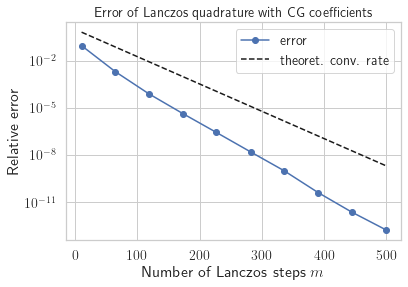

In [357]:
errs = (trueval - torch.tensor(quadrature_estimates)).abs() / trueval
#bound = compute_quadrature_upperbound(eigs, ms, x)
plt.semilogy(ms, errs, '-o', label='error')
plt.semilogy(ms, convergence_rate**ms, '--k', label='theoret. conv. rate')
plt.xlabel('Number of Lanczos steps $m$')
plt.ylabel('Relative error')
plt.title('Error of Lanczos quadrature with CG coefficients')
plt.legend();

Question: why works better if linspace eigvals? => if logspace, more clustered, Lanczos works best with well separated eigvals?

# Bounds on $N$, $m$

In [5]:
from math import log10

def build_A(n: int, lmin: float, lmax: float, device='cuda'):
    assert lmin > 0
    
    Q = torch.from_numpy(ortho_group.rvs(n)).to(device)
    eigs = torch.logspace(log10(lmin), log10(lmax), n, device=device)
    A = Q @ torch.diag(eigs) @ Q.T
    
    return A, eigs

In [6]:
A, eigs = build_A(1000, 1, 10000)

In [19]:
# True logdet
eigs.log().sum(), torch.logdet(A)

(tensor(4605.1702, device='cuda:0'), tensor(4605.1702, device='cuda:0'))

In [7]:
relerr = 0.05
proba_error = 0.5

Nmin, m_min = compute_logdet_bounds(eigs, relerr, proba_error)
Nmin, m_min

(17.753737976206686, 416.78731981107336)

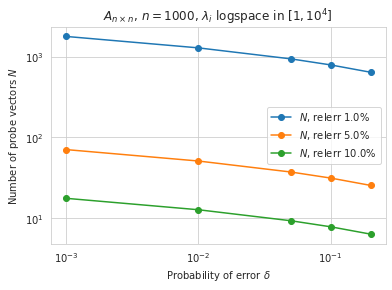

In [33]:
relerrs = (0.01, 0.05, 0.1)
probas = (0.001, 0.01, 0.05, 0.1, 0.2)


for relerr in relerrs:
    bounds = [
        compute_logdet_bounds(eigs, relerr, proba)
        for proba in probas
    ]
    Ns, ms = zip(*bounds)
    plt.plot(probas, Ns, '-o', label=f'$N$, relerr {relerr*100}%')

plt.legend()
plt.yscale('log'); plt.xscale('log')
plt.tick_params(axis='y', which='minor')
plt.xlabel('Probability of error $\delta$')
plt.ylabel('Number of probe vectors $N$')
plt.title(r'$A_{n \times n}, \, n = 1000$, $\lambda_i$ logspace in $[1, 10^4]$');

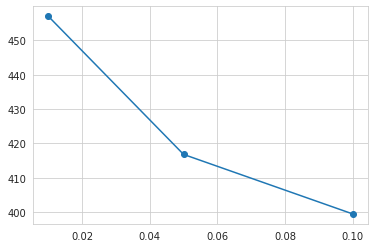

In [68]:
ms = [
    compute_logdet_bounds(eigs, relerr, 0.1)[1]
    for relerr in relerrs
]
plt.plot(relerrs, ms, '-o')

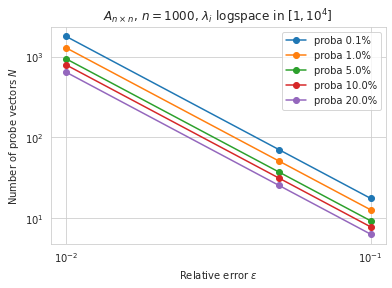

In [25]:
relerrs = (0.01, 0.05, 0.1)
probas = (0.001, 0.01, 0.05, 0.1, 0.2)

for proba in probas:
    bounds = [
        compute_logdet_bounds(eigs, relerr, proba)
        for relerr in relerrs
    ]
    Ns, ms = zip(*bounds)
    plt.plot(relerrs, Ns, '-o', label=f'proba {proba*100}%')

#plt.xscale('log')
plt.legend()
plt.yscale('log'); plt.xscale('log')
plt.tick_params(axis='y', which='minor')
plt.xlabel('Relative error $\epsilon$')
plt.ylabel('Number of probe vectors $N$')
plt.title(r'$A_{n \times n}, \, n = 1000$, $\lambda_i$ logspace in $[1, 10^4]$');

# Logdet of SPD matrix

In [27]:
from src.inference import compute_logdet

## Logdet without preconditionning

We don't use preconditionning here, so the matrix has to be well-conditionned, otherwise the number of Lanczos steps will be too big.

In [52]:
from math import log10

def build_A(n: int, lmin: float, lmax: float, logspace: bool = True, device='cuda'):
    assert lmin > 0
    
    Q = torch.from_numpy(ortho_group.rvs(n)).to(device)
    if logspace:
        eigs = torch.logspace(log10(lmin), log10(lmax), n, device=device)
    else:
        eigs = torch.linspace(lmin, lmax, n, device=device)
    A = Q @ torch.diag(eigs) @ Q.T
    
    return A, eigs

In [82]:
A, eigs = build_A(n=1000, lmin=1, lmax=1e2, logspace=True, device='cpu')

compute_logdet_bounds(eigs, 0.05, 0.05)

(37.41322728914573, 36.49501263710895)

In [84]:
%%time
Ns = (10, 37, 50, 100)
m = 37
reps = 1000

results = []
for N in Ns:
    # The estimates are iid, so compute everything in one shot
    estimates = compute_logdet(A, N*reps, m, return_avg=False)
    # Compute the averages for each independent run
    estimates = estimates.reshape(reps, N).mean(axis=1)
    results.append(estimates)

CPU times: user 11min 48s, sys: 2min 24s, total: 14min 13s
Wall time: 2min 57s


In [101]:
true = eigs.log().sum().item()
rel_errors_perc = np.abs(np.array(results) - true) / true * 100
rel_errors_perc

array([[1.37285149, 1.06600406, 0.58785305, ..., 1.57906322, 1.44397915,
        2.71377201],
       [0.53399371, 0.57004062, 1.62728347, ..., 0.61725416, 0.83215492,
        0.1599653 ],
       [0.41959915, 0.45693282, 0.79778446, ..., 0.0362663 , 0.36864048,
        0.09671768],
       [0.59246946, 0.87126263, 0.2813759 , ..., 1.01137869, 0.13781759,
        0.16449207]])

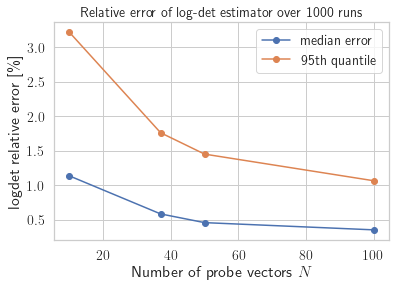

In [119]:
# Mean errors
plt.plot(Ns, np.median(rel_errors_perc, axis=1), '-o', label='median error')
# 95th Quantile
q = np.quantile(rel_errors_perc, 0.95, axis=1)

plt.title(f'Relative error of log-det estimator over {reps} runs')
plt.plot(Ns, q, '-o', label='95th quantile')
plt.ylabel('logdet relative error [\%]')
plt.xlabel('Number of probe vectors $N$')
plt.legend();

## Logdet with preconditionning

In [214]:
from src.inference import inference

In [277]:
n, k = 1000, 100
sigma2 = 1.0

A, eigs = build_A(n=n, lmin=1, lmax=100, logspace=True, device='cpu')
Ahat = A + sigma2 * torch.eye(n)

In [278]:
precond_eigs = compute_precond_eigs(A, k, sigma2)

In [279]:
precond_eigs.max() / precond_eigs.min()

tensor(87.1479)

In [282]:
compute_logdet_bounds(precond_eigs, 0.05, 0.05)

(37.93488325163729, 34.11409077025247)

In [292]:
inference(A, k, sigma2, N=50, m=40)

1016.8034604802733

In [284]:
P.logdet()

388.08751617983717

In [285]:
torch.logdet(A + sigma2 * torch.eye(n))

tensor(2479.1908)

In [129]:
n, k = 100, 30

M = torch.randn(n, n)
A = M @ M.T
Ahat = A + torch.eye(n) 
P = PartialCholesky(A, k, 1.0)

In [131]:
Pkhat = P.Pk_hat()

precond_mx = P.inv_fun(Ahat)
torch.logdet(precond_mx)

tensor(226.6356)

In [136]:
torch.logdet(Ahat) - P.logdet()

tensor(226.6356)

## Check sampling

In [183]:
n = 10
M = torch.randn(n, n)
S = M @ M.T

In [186]:
P = PartialCholesky(S, k=3, sigma2=1)

In [190]:
errs=[]
for N in Ns:
    Y = P.sample_gaussian(size=N)
    Ycov = torch.cov(Y)
    errs.append(torch.frobenius_norm(P.Pk_hat() - Ycov))

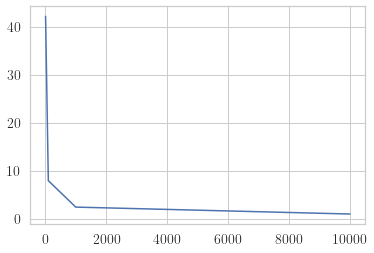

In [192]:
plt.plot(Ns, errs)

In [180]:
Ns = (10, 100, 1000, 10000)
errs = []
for N in Ns:
    X = torch.randn(n, N)
    Y = (M + torch.randn_like(M) * 0.5) @ X
    err = torch.frobenius_norm(S - torch.cov(Y))
    errs.append(err)

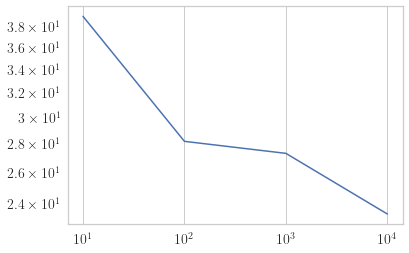

In [181]:
plt.loglog(Ns, errs)

In [162]:
N = 10000
X = torch.randn(n, N)
Y = M @ X

In [163]:
Semp = torch.cov(Y)

In [165]:
torch.frobenius_norm(Semp - S)

tensor(0.9195)

In [152]:
(S - Semp).abs().max()

tensor(2.4258)

In [139]:
Y.shape

torch.Size([10, 100])

# Check mbcg

In [559]:
# Conjugate gradients from scipy library
from scipy.sparse.linalg import cg as sp_cg

In [585]:
def callback(error_lst, xtrue):
    """
    Helper callback function: iterative methods (e.g, CG) can be provided a callback function,
    i.e. a function that will be called at each step of the iterative method with the input
    being the current solution. 
    This helper function provides a concise way of measuring the error at each step.
    
    :param error_lst: the list in which errors will be stored at each step
    :param xtrue: the true solution used to compute the error
    """
    xtrue_norm = (xtrue ** 2).sum()
    def inner(xk):
        """Wrapped function. `inner` will be called by the iterative methhod."""
        error_stepk = xk - xtrue
        # Compute l2-norm
        error_stepk = (error_stepk ** 2).sum() ** 0.5 / xtrue_norm
        error_lst.append(error_stepk)
        
    return inner

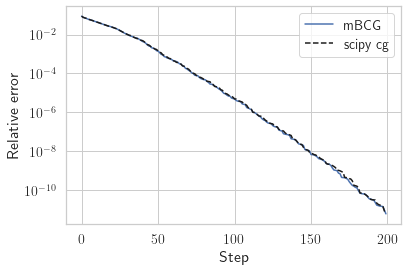

In [579]:
# === Generate the matrix A from its eigendecomposition
# Size of the matrix
n = 100
# Generate random orthogonal matrix
Q = torch.from_numpy(ortho_group.rvs(n))
# Generate eigenvalues
eigs = torch.logspace(0, 3, n)
#eigs = torch.linspace(1, 1e3, n)
# Compute A explicitly
A = Q @ torch.diag(eigs) @ Q.T

# === Generate solution and then the RHS of equation Ax = b
x = torch.randn(n)
b = A @ x

# === Approximation with iterative methods
# Starting solution for iterative methods
x0 = torch.zeros(n)
# Number of steps
k = 2*n

# mBCG algorithm
errors_mbcg = []
xk, _ = mbcg(lambda X: A@X, lambda X: X, b, torch.zeros_like(b), k, callback=callback(errors_mbcg, x))

# scipy reference algorithm
errors_sp = []
sp_cg(A.numpy(), b.numpy(), x0.numpy(), tol=1e-16, maxiter=k, callback=callback(errors_sp, x.numpy()));

# === Plot the errors
plt.semilogy(errors_mbcg, label='mBCG')
plt.semilogy(errors_sp, '--k', label='scipy cg')
plt.legend()
plt.xlabel('Step'); plt.ylabel('Relative error');

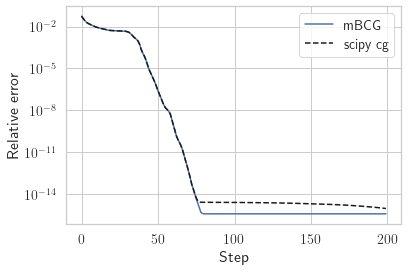

In [580]:
# === Generate the matrix A from its eigendecomposition
# Size of the matrix
n = 100
# Generate random orthogonal matrix
Q = torch.from_numpy(ortho_group.rvs(n))
# Generate eigenvalues
eigs = torch.linspace(1, 1e3, n)
#eigs = torch.linspace(1, 1e3, n)
# Compute A explicitly
A = Q @ torch.diag(eigs) @ Q.T

# === Generate solution and then the RHS of equation Ax = b
x = torch.randn(n)
b = A @ x

# === Approximation with iterative methods
# Starting solution for iterative methods
x0 = torch.zeros(n)
# Number of steps
k = 2*n

# mBCG algorithm
errors_mbcg = []
xk, _ = mbcg(lambda X: A@X, lambda X: X, b, torch.zeros_like(b), k, callback=callback(errors_mbcg, x))

# scipy reference algorithm
errors_sp = []
sp_cg(A.numpy(), b.numpy(), x0.numpy(), tol=1e-16, maxiter=k, callback=callback(errors_sp, x.numpy()));

# === Plot the errors
plt.semilogy(errors_mbcg, label='mBCG')
plt.semilogy(errors_sp, '--k', label='scipy cg')
plt.legend()
plt.xlabel('Step'); plt.ylabel('Relative error');